In [1]:
#For Google Colaboratory
#!pip install PyPolyaGamma
#!pip install 'pymc>=5.9' | tail -n 1
#!pip install numpyro | tail -n 1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for PyPolyaGamma: filename=pypolyagamma-1.2.3-cp310-cp310-linux_x86_64.whl size=778492 sha256=590b6079ad9f87a4aee3416aaf8da0debe6bafdcff72407f709d30437d279e30
  Stored in directory: /root/.cache/pip/wheels/56/83/bd/0378099f2c88026b81d825c119a47b94f100f1e748b2be04fa
Successfully built PyPolyaGamma


In [11]:
#For Google Colaboratory
#from google.colab import drive
#drive.mount("/content/gdrive")
#CHANGE#
FILEPATH = "/content/gdrive/My Drive/MCMCOptimism/code/public/"
#import sys
#sys.path.append(FILEPATH)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.special import gammaln

from joblib import Parallel, delayed
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import itertools


import pymc as pm
import arviz as az
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from pypolyagamma import logistic, PyPolyaGamma
from psis import psisloo, psislw, gpdfitnew, gpinv, sumlogs

import warnings
warnings.filterwarnings("ignore")



import matplotlib
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['axes.xmargin'] = 0
matplotlib.rcParams['axes.ymargin'] = 0

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

#Logistic regression


Bayesian logistic regression model is a Bayesian version of the popular logistic regression model. We assume a Gaussian prior on regression coefficients.
Then, the working model is
\begin{align*}
Y(i) \mid X(i) \,,\, \beta &\sim
\mathrm{Bernoulli}(\sigma(X(i)\beta) )\,\, (i=1,\ldots,n),
\\
\beta &\sim \mathrm{Normal}(0,I),
\end{align*}
where $\sigma(x)=1/\{1+\exp(-x)\}$.



The comparison utilizes the banknote authentication data / adult data
from UCI Machine Learning Repository.

We conduct MCMC using Polya-Gamma augumentation.

In [14]:
def baylogit(Xs,Ys,pos_samples = 20000,thinning    = 10,burnin      = 10000, beta_sigma2=1,rho=1):
  #Input:
      #Xs: Xs in logistic regression
      #Ys: Ys in logistic regression
      #pos_samples: number of posterior samples
      #thinning: set-up of thinning
      #burinin: set-up of burinin period
      #beta_sigma2: set-up of prior variance
  #Output:
      #Posterior samples of beta
    pg = PyPolyaGamma(seed=0)
    n   = Ys.shape[0]
    dim = Xs.shape[1]
    omegas = np.ones((n,pos_samples))
    betas = np.ones((dim, pos_samples))
    beta_sigma2 = beta_sigma2 / rho
    for i in range(1, pos_samples):

        omegas[:,i] = [pg.pgdraw(rho, Xs[s,:].dot(betas[:,i-1])) for s in range(n)]
        V_omega = np.linalg.inv( Xs.T @ np.diag(omegas[:,i]) @ Xs+ (1/beta_sigma2)*np.eye(dim) )
        mu_omega = V_omega @ (Xs.T @ (Ys-1/2) * rho)
        betas[:,i] = multivariate_normal.rvs(
        mean=mu_omega[:],
        cov=V_omega,
        size=1)
    final_betas = betas[:,range(burnin,pos_samples,thinning)]
    return final_betas

In [15]:
def sigmoid(x):
    # Activation function used to map any real value between 0 and 1
    return 1 / (1 + np.exp(-x))

def log_loss(psi,Y):
    ret = Y*np.log(sigmoid(psi))+(1-Y)*np.log(1-sigmoid(psi))
    return ret

def brier_loss(psi,Y):
    ret = (Y-sigmoid(psi))**2
    return ret

def misclassification_loss(psi,Y):
    decision = (sigmoid(psi)>1/2)*1
    return (-1)*(decision==Y)

def spherical_loss(psi,Y):
    denominator = np.sqrt(sigmoid(psi)**2 + (1-sigmoid(psi))**2)
    nominator = Y*sigmoid(psi)+(1-Y)*(1-sigmoid(psi))
    ret = nominator/denominator
    return (-1)*ret

def pseudo_spherical_loss(psi,Y,beta):
    denominator = (sigmoid(psi)**beta + (1-sigmoid(psi))**beta)**((beta-1)/beta)
    nominator = (Y*sigmoid(psi))**(beta-1)+((1-Y)*(1-sigmoid(psi)))**(beta-1)
    ret = nominator/denominator
    return (-1)*ret

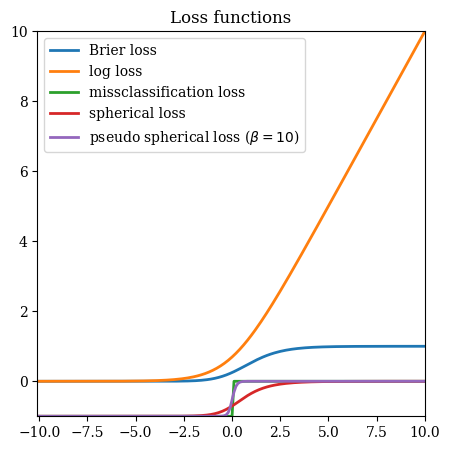

In [16]:
#Check the relationship between losses
range_psi = [0.1*i for i in range(-101,101)]
fig = plt.figure(figsize=(5,5))
plt.title("Loss functions")
plt.plot(range_psi , [brier_loss(psi,0) for psi in range_psi],label="Brier loss")
plt.plot(range_psi , [-log_loss(psi,0) for psi in range_psi],label="log loss")
plt.plot(range_psi , [misclassification_loss(psi,0) for psi in range_psi],label="missclassification loss")
plt.plot(range_psi, [spherical_loss(psi,0) for psi in range_psi],label="spherical loss")
plt.plot(range_psi, [pseudo_spherical_loss(psi,0,10) for psi in range_psi],label="pseudo spherical loss ("+r"$\beta=10$"+")")
plt.legend()

In [17]:

df_banknote = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt",header=None)
df_banknote.columns = ["Variance","Skewness","Curtosis","Entropy","Class"]
df_adult=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', sep=',',names = ['Age', 'Workclass', 'Fnlwgt', 'Education','Education num','Marital Status',
                                          'Occupation','Relationship','Race','Sex','Capital Gain','capital loss',
                                          'Hour per week',
                                          'Native country','Class'])
df_adult.dropna(how="all",inplace=True)
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
le= LabelEncoder()
for col in df_adult.columns:
    if df_adult[col].dtypes=='object':
        df_adult[col]= le.fit_transform(df_adult[col])

In [18]:

exp_num = 1
print(exp_num)
random.seed(exp_num)
np.random.seed(exp_num)


database = "adult"
n_train = 50
n_test  = 50
loss = misclassification_loss
sc = StandardScaler()
n_jobs = 3

#####################################################################
if(database=="banknote"):
      n    =1372
      list_train=random.sample([i for i in range(n)], n_train)
      list_test =random.sample(list(set([i for i in range(n)]) - set(list_train)),n_test)
elif(database=="adult"):
      n=df_adult.shape[0]
      list_train=random.sample([i for i in range(n)], n_train)
      list_test =random.sample(list(set([i for i in range(n)]) - set(list_train)),n_test)

if(database=="banknote"):
      target_data = pd.DataFrame(sc.fit_transform(df_banknote.iloc[0::,0:-1]))
      target_data.columns=df_banknote.columns[0:-1]
      target_data["Class"] = df_banknote["Class"]
      print("banknote")
elif(database=="adult"):
      target_data = pd.DataFrame(sc.fit_transform(df_adult.iloc[0::,0:-1]))
      target_data.columns=df_adult.columns[0:-1]
      target_data["Class"] = df_adult["Class"]
      print("adult")

Xs_train  = np.hstack((np.array(target_data.iloc[list_train,0:-1]),np.ones(n_train).reshape(n_train, 1)))
Ys_train  = np.array(target_data["Class"][list_train])
Xs_test  = np.hstack((np.array(target_data.iloc[list_test,0:-1]),np.ones(n_test).reshape(n_test, 1)))
Ys_test  = np.array(target_data["Class"][list_test])
#####################################################################


# Generate beta samples
rholist = [0.1 + 0.1 * i for i in range(10)]
final_betas_list = Parallel(n_jobs=-1)(
    delayed(baylogit)(Xs=Xs_train, Ys=Ys_train, pos_samples=20000, thinning=1, burnin=100, beta_sigma2=1, rho=rho)
    for rho in rholist
)


# Initialize result lists
Em, PCIC, PSIS, Vehtari2002, VO2012, IS, Gen = [], [], [], [], [], [], []



for k in range(len(rholist)):
      Tk=[]
      Vk=[]
      Vehtari2002_Vk = []
      Vehtari2002_Tk = []
      VO2012_Vk      = []
      pos_likes = []
      pos_losses = []
      ISn=[]

      for n in range(n_train):
          pos_loss=loss((Xs_train[n] @ final_betas_list[k])[:],Ys_train[n])
          pos_losses.append(pos_loss)
          pos_like=log_loss((Xs_train[n] @ final_betas_list[k])[:],Ys_train[n])
          pos_likes.append(pos_like)
          plugin_loss = loss(Xs_train[n] @ np.mean(final_betas_list[k],axis=1),Ys_train[n])
          predictors  = sigmoid((Xs_train[n] @ final_betas_list[k])[:])
          Tk.append(np.nanmean(pos_loss))
          Vk.append(np.cov(pos_loss,pos_like)[0,1])
          Vehtari2002_Vk.append(2*(plugin_loss-np.mean(pos_loss)))
          Vehtari2002_Tk.append(np.mean(pos_loss))
          VO2012_Vk.append(np.var(predictors))
          nom= loss((Xs_train[n] @ final_betas_list[k])[:],Ys_train[n])*np.exp(-(rholist[k])* log_loss((Xs_train[n] @ final_betas_list[k])[:],Ys_train[n]))
          denom=np.exp(-(rholist[k])* log_loss((Xs_train[n] @ final_betas_list[k])[:],Ys_train[n]))
          ISn.append(np.nanmean(nom)/np.nanmean(denom))

      lw = -rholist[k]*np.array(pos_likes)
      PSIS_weight=np.exp(psislw(lw)[0])
      PSIS.append(np.nanmean(np.diag((np.nan_to_num(PSIS_weight,nan=0) @ np.nan_to_num(np.array(pos_losses), nan=0).T)/np.nansum(PSIS_weight,axis=1))))

      PCIC.append(np.nanmean(Tk)-(rholist[k])*np.nanmean(Vk))
      Vehtari2002.append(np.nanmean(Vehtari2002_Tk)-np.nanmean(Vehtari2002_Vk))
      VO2012.append(np.nanmean(Tk)+np.nanmean(VO2012_Vk))
      Em.append(np.nanmean(Tk))
      IS.append(np.nanmean(ISn))


      def compute_gk(k):
          predictions = [Xs_test[n] @ final_betas_list[k] for n in range(n_test)]
          pos_loss = [loss(pred, Ys_test[n]) for pred, n in zip(predictions, range(n_test))]
          return np.mean(pos_loss)
      Gen= Parallel(n_jobs=n_jobs)(delayed(compute_gk)(k) for k in range(len(rholist)))

1
adult


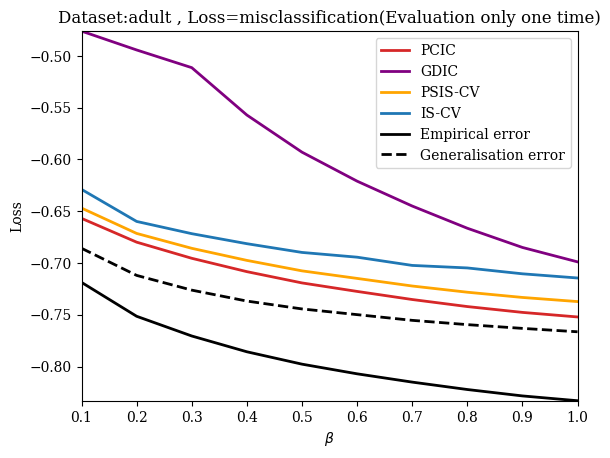

In [21]:
lossname= "misclassification"
plt.plot(rholist,PCIC,label="PCIC",color="tab:red")
plt.plot(rholist,Vehtari2002,label="GDIC",color="purple")
plt.plot(rholist,PSIS,label="PSIS-CV",color="orange")
plt.plot(rholist,IS,label="IS-CV",color="tab:blue")
plt.plot(rholist,Em,label="Empirical error",color="black")
plt.plot(rholist,Gen,"--",label="Generalisation error",color="black")
plt.legend()
plt.title("Dataset:"+database+" , Loss="+lossname + "(Evaluation only one time)")
plt.xlabel(r"$\beta$")
plt.ylabel("Loss")
plt.show()

#Bayesian hierarchical modeling

Here we check the behaviours in a simple two-level normal model:
\begin{align*}
X_{ij} &\sim \mathcal{N}(\theta_{j},v_{j}^{2}),\quad
i=1,\ldots,n_{j},\quad
j=1,\ldots,J\\
\theta_{i} & \sim \mathcal{N}(\mu,\tau^{2}),\quad
j=1,\ldots,J,
\end{align*}
where $v_{j}^{2}$s are assumed to be given,
$n_{j}$ is the sample size of the $j$-th group ($j=1,\ldots,J$),
and $J$ is the number of groups.
Here we assume that $n_{j}$ is equal to 1 and denote $X_{ij}$ by $X_{j}$, which is always possible by the sufficiency reduction.
The prior distributions of $\mu$ and $\tau$ are specified by the scale mixture of the normal distribution with the half Cauchy distribution and
by the half normal distribution, respectively:
\begin{align*}
\mu \mid \sigma^{2}_{\mu}&\sim \mathcal{N}(0,\sigma^{2}_{\mu}),\quad
\sigma^{2}_{\mu} \sim \mathrm{Half}\mathcal{C}(\gamma),\quad\text{and}\\
\tau & \sim \mathrm{Half}\mathcal{N}(\sigma_{\tau}),
\end{align*}
where $\gamma$ and $\sigma_{\tau}$ are hyper parameters.
Consider the prediction accuracy by (unscaled) $\ell_{2}^{2}$ loss
\begin{align*}
\nu(X_{j},\mu)=|X_{j}-\mu|^{2}
\end{align*}
and use two datasets commonly used in the demonstration of the Bayesian hierarchical modeling.

In [23]:
def log_like_BHM(mu,tau,Y,sigma):
    ret1 = -(Y-mu)**2/(2*(sigma**2+tau**2))
    ret2 = -np.log(np.sqrt(2*np.pi)*np.sqrt(sigma**2+tau**2))
    return ret1+ret2

def l2_loss(mu,Y):
    ret = (Y-mu)**2
    return ret


In [32]:
dataset_BHM = "8school" #"Yusuf"
if dataset_BHM == "Yusuf":
  J = 22
  J_train = J // 2
elif dataset_BHM == "8school":
  J = 8
  J_train = J // 2
############################################

final_mu_list = []
final_tau_list = []
final_theta_list = []
exp_num_list = range(1)
var_scale_list = range(1,11)
prior_scale_list = 0.1*np.array(range(1,11))

pos_samples = 5000
loss_BHM=l2_loss



def run_model(exp_num, y, sigma, hypertau, hypermu,pos_samples):
    random.seed(exp_num)
    np.random.seed(exp_num)
    split = random.sample([i for i in range(J)], J_train)
    split_remaining = [i for i in range(J) if i not in split]
    with pm.Model() as model:
        mu_sigma = pm.HalfCauchy("mu_sigma", beta=hypermu)
        mu = pm.Normal("mu", mu=0, sigma=mu_sigma)
        tau = pm.HalfNormal("tau", sigma=hypertau)
        theta_raw = pm.Normal("theta_raw", mu=0, sigma=1, shape=len(y[split]))
        theta = pm.Deterministic("theta", mu + theta_raw * tau)
        y_obs = pm.Normal("y_obs", mu=theta, sigma=sigma[split], observed=y[split])

        trace = pm.sample(pos_samples, return_inferencedata=True, cores=1,target_accept = 0.95, progressbar=False)

    mu_values = trace.posterior["mu"]
    tau_values = trace.posterior["tau"]
    theta_values = trace.posterior["theta"]
    y_remaining = y[split_remaining]
    y_train = y[split]
    sigma_train = sigma[split]

    return mu_values, tau_values, theta_values, y_remaining ,y_train, sigma_train

PCIC_result_BHM, PSIS_result_BHM, Vehtari2002_result_BHM, IS_result_BHM, Em_result_BHM, Gen_result_BHM = [], [], [], [], [], []
for var_scale in var_scale_list:

  if dataset_BHM == "Yusuf":
    sigma = np.array([0.850,0.483,0.565,0.138,0.281,
                  0.676,0.139,0.204,0.274,0.117,
                  0.195,0.229,0.425,0.205,0.298,
                  0.261,0.364,0.553,0.717,0.260,
                  0.257,0.272])
    hypermu =  10
    hypertau = 10

    y = (np.array([0.028, -0.741,-0.541,-0.246,0.069,
              -0.584,-0.512,-0.079,-0.424,-0.335,
              -0.213,-0.039,-0.593,0.282,-0.321,
              -0.135,0.141,0.322,0.444,-0.218,
              -0.591,-0.608 ]))
    y = var_scale*y

  elif dataset_BHM == "8school":
    sigma = np.array([15, 10, 16, 11,  9, 11, 10, 18])  # 標準偏差
    y =     np.array([28,  8, -3,  7, -1,  1, 18, 12])  # 効果サイズ
    y = var_scale*y
    hypermu = 10
    hypertau = 10

  final_mu_list = []
  final_tau_list = []
  final_theta_list = []
  y_remaining_list = []
  y_train_list     = []
  sigma_train_list = []

  with ProcessPoolExecutor() as executor:
      results = list(executor.map(partial(run_model, y=y, sigma=sigma,hypertau=hypertau, hypermu=hypermu, pos_samples=pos_samples,), exp_num_list))
  for mu_values, tau_values, theta_values, y_remaining, y_train, sigma_train in results:
      final_mu_list.append(mu_values.values[-1,:])
      final_tau_list.append(tau_values.values[-1,:])
      final_theta_list.append(theta_values.values[-1,:])
      y_remaining_list.append(y_remaining)
      y_train_list.append(y_train)
      sigma_train_list.append(sigma_train)

  Em      = []
  PCIC = []
  PSIS = []
  Vehtari2002 = []
  IS = []
  Gen = []


  for k in range(len(exp_num_list)):
      Tk=[]
      Vk=[]
      Vehtari2002_Vk=[]
      Vehtari2002_Tk=[]
      pos_likes = []
      pos_losses = []
      pos_modiflikes = []
      gens = []
      for j in range(J-J_train):
          gens.append(np.mean(np.array([loss_BHM(final_mu_list[k][i],
                                                y_remaining_list[k][j]) for i in range(pos_samples)])))
      Gen.append(np.mean(gens))

      for n in range(J_train):
          pos_loss=np.array([loss_BHM(final_mu_list[k][i],y_train_list[k][n]) for i in range(pos_samples)])
          pos_losses.append(pos_loss)
          pos_like=np.array([log_like_BHM(final_mu_list[k][i],final_tau_list[k][i],
                                      y_train_list[k][n],sigma_train_list[k][n]) for i in range(pos_samples)])
          pos_likes.append(pos_like)

          plugin_loss = loss_BHM(np.mean(final_mu_list[k]),y_train_list[k][n])
          Tk.append(np.nanmean(pos_loss))
          Vk.append(np.cov(pos_loss,pos_like)[0,1])

          Vehtari2002_Vk.append(2*(plugin_loss-np.nanmean(pos_loss)))
          Vehtari2002_Tk.append(np.nanmean(pos_loss))

      lw = -np.array(pos_likes)
      PSIS_weight=np.exp(psislw(lw)[0])
      PSIS.append(np.nanmean(np.diag((PSIS_weight @ np.array(pos_losses).T)/PSIS_weight.sum(axis=1))))

      PCIC.append(np.nanmean(Tk)-np.nanmean(Vk))
      Vehtari2002.append(np.nanmean(Vehtari2002_Tk)-np.nanmean(Vehtari2002_Vk))
      Em.append(np.nanmean(Tk))


      ISn=[]

      for n in range(J_train):
          nom= np.array([loss_BHM(final_mu_list[k][i],y_train_list[k][n]) for i in range(pos_samples)])*np.exp(
              -np.array([log_like_BHM(final_mu_list[k][i],final_tau_list[k][i],
                                      y_train_list[k][n],sigma_train_list[k][n]) for i in range(pos_samples)]))
          denom=np.exp(-np.array([log_like_BHM(final_mu_list[k][i],final_tau_list[k][i],
                                      y_train_list[k][n],sigma_train_list[k][n]) for i in range(pos_samples)]))
          ISn.append(np.mean(nom)/np.mean(denom))

      IS.append(np.mean(ISn))

  print(np.mean(IS),np.mean(PCIC),np.mean(PSIS),np.mean(Vehtari2002),np.mean(Em),np.mean(Gen))

  IS_result_BHM.append(np.mean(IS))
  PCIC_result_BHM.append(np.mean(PCIC))
  PSIS_result_BHM.append(np.mean(PSIS))
  Vehtari2002_result_BHM.append(np.mean(Vehtari2002))
  Em_result_BHM.append(np.mean(Em))
  Gen_result_BHM.append(np.mean(Gen))

ERROR:pymc.stats.convergence:There were 142 divergences after tuning. Increase `target_accept` or reparameterize.


219.02414941205677 209.4045255333751 181.78972048677394 268.2588822454026 159.16489725172414 142.4596512935139


ERROR:pymc.stats.convergence:There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


605.0842745818284 536.2739307634745 458.0084401689365 539.0879659027557 365.63220393899337 738.9820041021705


ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


1244.6169314324331 1039.4019490017545 891.9869196635336 943.2521549675507 703.1893351998292 1819.343895462529
2129.730131431152 1729.6536634871184 1484.391553373035 1483.1959988701883 1168.8304552102504 3379.172639185338
2896.9706499701374 2597.627031953139 2215.494713835172 2151.5726754601283 1756.233561607903 5475.1806133841
4192.97600357395 3686.4767192247673 3100.433294469818 2949.9572882501525 2470.972271448218 8022.169533718406
5523.649197754177 4911.03743609806 4149.600710580533 3874.551695540459 3313.5620023444603 10942.322985695275
6764.098842554373 6296.483190494597 5316.543488972826 4885.152196028367 4262.023527440845 14437.176649575109
8500.445280987948 7806.060472002581 6608.7663889979685 5996.418799036665 5324.755304737647 18440.93861717395
10273.850649532551 9632.972624366404 8056.681676139071 7306.573202671672 6535.431333931734 22962.130416416032


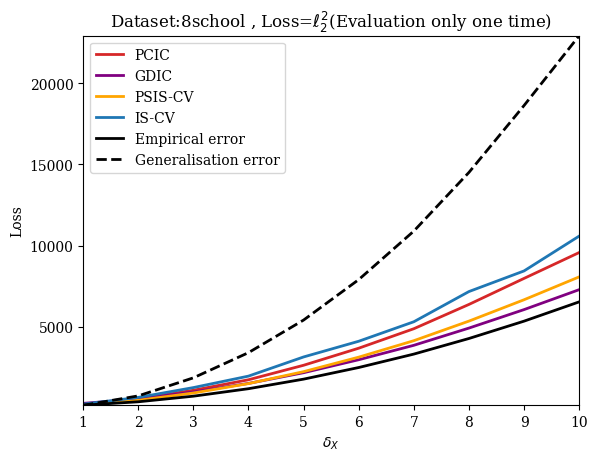

In [34]:
lossname= r"$\ell_{2}^{2}$"
plt.plot(var_scale_list,PCIC_result,label="PCIC",color="tab:red")
plt.plot(var_scale_list,Vehtari2002_result,label="GDIC",color="purple")
plt.plot(var_scale_list,PSIS_result,label="PSIS-CV",color="orange")
plt.plot(var_scale_list,IS_result,label="IS-CV",color="tab:blue")
plt.plot(var_scale_list,Em_result,label="Empirical error",color="black")
plt.plot(var_scale_list,Gen_result,"--",label="Generalisation error",color="black")
plt.legend()
plt.title("Dataset:"+dataset_BHM+" , Loss="+lossname + "(Evaluation only one time)")
plt.xlabel(r"$\delta_{X}$")
plt.ylabel("Loss")
plt.show()

#High dimensional Poisson models

Poisson sequence model is a gold-standard starting point of count-data analysis.
Here we employ the high-dimensional Poisson model with the Stein-type shrinkage prior proposed by Komaki (2006):
\begin{align*}
Y(i) =(Y_{1}(i),\ldots, Y_{d}(i))\mid \lambda=(\lambda_{1},\ldots,\lambda_{d}) &\sim \otimes_{i=1}^{d} \mathrm{Poisson}(\lambda_{i}) \,\, (i=1,\ldots,n),\\
\pi(\lambda)&= \frac{\lambda_{1}^{\beta_{1}-1}\cdots\lambda_{d}^{\beta_{d}-1}}{(\lambda_{1}+\cdots+\lambda_{d})^{\alpha}},
\end{align*}


Sampling from Komaki's shrinkage prior for Poisson models is as follows:

*   Model:
$X_{i} \sim Po(r \lambda_i ),\,i=1,\ldots,d$ where $r$ is the sample size.


*   Prior:
$\pi_{\alpha,\beta}(\lambda)=\frac{\lambda_{1}^{\beta_{1}-1}\cdots\lambda_{d}^{\beta_{d}-1}}{(\lambda_{1}+\cdots+\lambda_{d})^\alpha}$

*  Posterior:
$\pi_{\alpha,\beta}(\lambda \mid x)\propto \left\{\prod_{i=1}^{d} \left(\frac{\lambda_{i}}{\|\lambda\|_{1}}\right)^{x_{i}+\beta_{i}-1}\right\} \left\{\|\lambda\|_{1}^{\sum_{i}(x_{i}+\beta_{i}-1)-\alpha}e^{-r\|\lambda\|_{1}}
\right\}$

* Change of variables $(\lambda_{1},\ldots,\lambda_{d}) \to (w_{1}=\lambda_{1}/\|\lambda\|_{1},\ldots,w_{d}=\lambda_{d}/\|\lambda\|_{1}, \mu=\|\lambda\|_{1})$

> * Jacobian: $\mu^{d-1}dw_{1}\ldots d w_{d-1}d\mu=d\lambda_{1}\ldots d\lambda_{d}$

> * Posterior: $\pi_{\alpha,\beta}(w,\mu \mid x)\propto \left\{\prod_{i=1}^{d} w_{i}^{x_{i}+\beta_{i}-1}\right\} \left\{\mu^{\sum_{i}(x_{i}+\beta_{i})-d-\alpha}e^{-r\mu}
\right\}\mu^{d-1} = \left\{\prod_{i=1}^{d} w_{i}^{x_{i}+\beta_{i}-1}\right\} \left\{\mu^{\sum_{i}(x_{i}+\beta_{i})-\alpha-1}e^{-r\mu}
\right\}$

*  Exact sampling from the posterior:

  1. First sample $\mu:=\|\lambda\|_{1}$ from $\mathrm{Gamma}(\mathrm{shape}=\sum(x_{i}+\beta_{i})-\alpha,\,\mathrm{scale}=1/r)$
  2. Then sample $(w_1,\ldots,w_d)$ from $\mathrm{Dirichlet}(x_1 + \beta_1 ,\ldots,x_d+\beta_d)$
  3. Output $\lambda_1=w_1 \mu,\ldots,\lambda_d=w_d \mu$



In [54]:
crime_data = pd.read_csv(FILEPATH+"crimedata_ja.csv",encoding="shift-jis",header=0,index_col=0)
crime_data = crime_data.fillna(0)
X_crime = crime_data.fillna(0).values
X_crime = X_crime.T

In [56]:
def possample_K04(X,hyperparam_beta,hyperparam_alpha,pos_num):
  #Input:
      #X: observations (n times d)
      #beta: dim-dimensional array
      #alpha: scalar
      #init: initial value for optimization
      #pos_num: int. for num of posterior samples
  #Output:
      #(posterior samples of mu, posterior samples of w, posterior samples of lambda)
  dim = X.shape[1]
  r   = X.shape[0]
  shape = X.sum()+hyperparam_beta.sum()-hyperparam_alpha
  scale = 1/r
  pos_lam_length = np.random.gamma(shape=shape,scale=scale,size=pos_num)
  alpha = X.sum(axis=0)+hyperparam_beta
  pos_w          = np.random.dirichlet(alpha=alpha,size=pos_num)
  return pos_lam_length, pos_w , np.array([ pos_lam_length[i]* pos_w[i] for i in range(pos_num)])

In [57]:

def log_likelihood_onedim_vectorized_HDP(mu, Xi):
    return Xi * np.log(mu) - mu - gammaln(Xi + 1)

def log_likelihood_HDP(mu, Xi):
    return np.sum(log_likelihood_onedim_vectorized_HDP(mu, Xi))

def minus_log_likelihood_HDP(mu, Xi):
    return -np.sum(log_likelihood_onedim_vectorized_HDP(mu, Xi))

def loss_l2_HDP(mu,Xi):
    return np.sum((mu-Xi)**2)

def loss_l1_HDP(mu,Xi):
    return np.sum(np.abs(mu-Xi))

def rmse_loss_HDP(mu, Xi):
    return np.sum(np.abs(np.sqrt(mu)-np.sqrt(Xi)))

In [58]:
def calculate_gen(pos_sam, X_tilde,loss):
      num_pos_sample, dim = pos_sam.shape
      M = X_tilde.shape[0]

      losses = np.zeros((M, num_pos_sample))
      for j in range(M):
          losses[j, :] = [
              loss(pos_sam[i, :], X_tilde[j, :]) for i in range(num_pos_sample)
          ]

      return np.mean(np.mean(losses, axis=1))

In [68]:

N = X_crime.shape[0]
dim = X_crime.shape[1]
num_pos_sample = 10000

lossname = "l2"
loss = loss_l2_HDP
N_list = [2,3,4,5,6]

PCIC_list_HDP = []
PSIS_list_HDP = []
ISCV_list_HDP = []
Gen_list_HDP = []
Em_list_HDP = []

for N_train in N_list:

  combinations = list(itertools.combinations(range(N), N_train))
  num_combinations = len(combinations)

  PCIC = []
  PSIS = []
  ISCV = []
  Gen  = []
  Em   = []

  for exp_num in range(num_combinations):
    print(exp_num)
    split = list(combinations[exp_num])
    split_remaining = list(set(range(N)) - set(split))
    print(split)
    X_train = X_crime[split,:]
    X_test  = X_crime[split_remaining,:]

    hyperparam_beta  = 3*np.ones(dim)
    hyperparam_alpha = sum(hyperparam_beta)-1
    pos_sam=possample_K04(X=X_train,hyperparam_beta=hyperparam_beta,hyperparam_alpha=hyperparam_alpha,pos_num=num_pos_sample)[2]


    Tk=[]
    Vk=[]
    pos_likes = []
    pos_losses = []

    Gen.append(calculate_gen(pos_sam, X_test,loss))

    for ni in range(N_train):
      pos_loss=np.array([loss(mu=pos_sam[i,:], Xi=X_train[ni,:]) for i in range(num_pos_sample)])
      pos_losses.append(pos_loss)
      pos_like=np.array([log_likelihood_HDP(mu=pos_sam[i,:], Xi=X_train[ni,:]) for i in range(num_pos_sample)])
      pos_likes.append(pos_like)

      Tk.append(np.nanmean(pos_loss))
      Vk.append(np.cov(pos_loss,pos_like)[0,1])

    PCIC.append(np.nanmean(Tk)-np.nanmean(Vk))
    Em.append(np.nanmean(Tk))

    lw = -np.array(pos_likes)
    PSIS_weight=np.exp(psislw(lw)[0])
    PSIS.append(np.nanmean(np.diag((PSIS_weight @ np.array(pos_losses).T)/PSIS_weight.sum(axis=1))))
    ISn=[]

    for ni in range(N_train):
      nom= np.array([loss(mu=pos_sam[i,:], Xi=X_train[ni,:]) for i in range(num_pos_sample)])*np.exp(
                    -np.array([log_likelihood_HDP(mu=pos_sam[i,:], Xi=X_train[ni,:]) for i in range(num_pos_sample)]))
      denom=np.exp(-np.array([log_likelihood_HDP(mu=pos_sam[i,:], Xi=X_train[ni,:]) for i in range(num_pos_sample)]))
      ISn.append(np.nanmean(nom)/np.nanmean(denom))

    ISCV.append(np.nanmean(ISn))
  PCIC_list_HDP.append(np.nanmean(np.array(PCIC)))
  PSIS_list_HDP.append(np.nanmean(np.array(PSIS)))
  ISCV_list_HDP.append(np.nanmean(np.array(ISCV)))
  Gen_list_HDP.append(np.nanmean(np.array(Gen)))
  Em_list_HDP.append(np.nanmean(np.array(Em)))

  print(np.nanmean(Gen),np.nanmean(Em),np.nanmean(PCIC),np.nanmean(PSIS),np.nanmean(ISCV))

0
[0, 1]
1
[0, 2]
2
[0, 3]
3
[0, 4]
4
[0, 5]
5
[0, 6]
6
[1, 2]
7
[1, 3]
8
[1, 4]
9
[1, 5]
10
[1, 6]
11
[2, 3]
12
[2, 4]
13
[2, 5]
14
[2, 6]
15
[3, 4]
16
[3, 5]
17
[3, 6]
18
[4, 5]
19
[4, 6]
20
[5, 6]
8600.710640833779 7077.567716911923 9698.980133897527 7039.069443251368 1289.8753365084192
0
[0, 1, 2]
1
[0, 1, 3]
2
[0, 1, 4]
3
[0, 1, 5]
4
[0, 1, 6]
5
[0, 2, 3]
6
[0, 2, 4]
7
[0, 2, 5]
8
[0, 2, 6]
9
[0, 3, 4]
10
[0, 3, 5]
11
[0, 3, 6]
12
[0, 4, 5]
13
[0, 4, 6]
14
[0, 5, 6]
15
[1, 2, 3]
16
[1, 2, 4]
17
[1, 2, 5]
18
[1, 2, 6]
19
[1, 3, 4]
20
[1, 3, 5]
21
[1, 3, 6]
22
[1, 4, 5]
23
[1, 4, 6]
24
[1, 5, 6]
25
[2, 3, 4]
26
[2, 3, 5]
27
[2, 3, 6]
28
[2, 4, 5]
29
[2, 4, 6]
30
[2, 5, 6]
31
[3, 4, 5]
32
[3, 4, 6]
33
[3, 5, 6]
34
[4, 5, 6]
7355.063998471727 6111.837388710483 8052.659124418255 6105.905758487399 inf
0
[0, 1, 2, 3]
1
[0, 1, 2, 4]
2
[0, 1, 2, 5]
3
[0, 1, 2, 6]
4
[0, 1, 3, 4]
5
[0, 1, 3, 5]
6
[0, 1, 3, 6]
7
[0, 1, 4, 5]
8
[0, 1, 4, 6]
9
[0, 1, 5, 6]
10
[0, 2, 3, 4]
11
[0, 2, 3, 5]
12
[0,

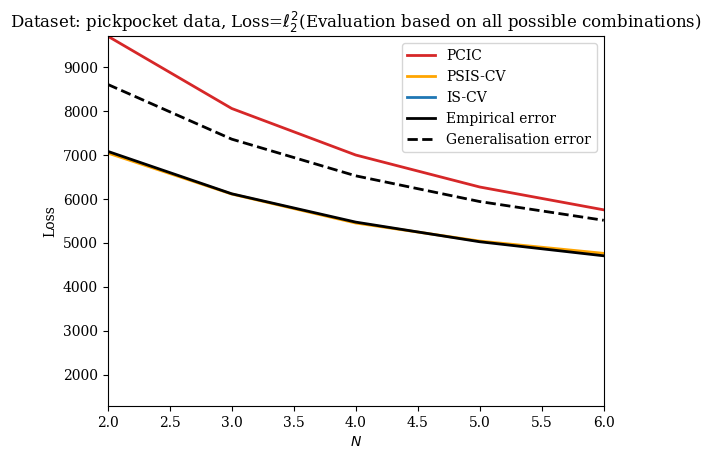

In [70]:
lossname= r"$\ell_{2}^{2}$"
plt.plot(N_list,PCIC_list_HDP,label="PCIC",color="tab:red")
plt.plot(N_list,PSIS_list_HDP,label="PSIS-CV",color="orange")
plt.plot(N_list,ISCV_list_HDP,label="IS-CV",color="tab:blue")
plt.plot(N_list,Em_list_HDP,label="Empirical error",color="black")
plt.plot(N_list,Gen_list_HDP,"--",label="Generalisation error",color="black")
plt.legend()
plt.title("Dataset: pickpocket data, Loss="+lossname + "(Evaluation based on all possible combinations)")
plt.xlabel(r"$N$")
plt.ylabel("Loss")
plt.show()